In [1]:
%matplotlib inline

In [ ]:
# This notebook plots annual anomalies in precipitation and temperature from the ERA5-Land reanalysis

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
from pathlib import Path
import pickle
import xarray as xr
import trend_analysis_final as trend_analysis
import pymannkendall as mk
from scipy.stats import theilslopes
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("colorblind") 
rcParams['font.family'] = 'Arial'
os.chdir(Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\Changes in streamflow in Iceland\Notebooks\June2024"))

# Process precipitation

In [6]:
# Path to your files
data_path = Path(r"C:/Users/hordurbhe/Documents/Vinna/lamah/lamah_ice/era5_land/data/")

# Function to create a time coordinate for each dataset manually
def add_time_coord(ds, year):
    hours_in_year = 8784 if year % 4 == 0 else 8760
    time = pd.date_range(f"{year}-01-01", periods=hours_in_year, freq='H')
    ds = ds.assign_coords(time=("time", time))
    return ds

# List of years
years = np.arange(1951, 2024)
# years = np.arange(2018, 2024)

# Dictionaries to store water-year accumulated precipitation, snowfall, and rainfall
water_year_accum_precip = {}
water_year_accum_snowfall = {}
water_year_accum_rainfall = {}

# Loop through each water year (Oct 1 of current year to Sep 30 of next year)
for year in years:
    print(year)
    try:
        # Load current year's dataset for precipitation and snowfall
        file_current_precip = data_path / f"ERA5-Land_total_precipitation_{year}.nc"
        file_current_snowfall = data_path / f"ERA5-Land_snowfall_{year}.nc"
        ds_precip_current = xr.open_dataset(file_current_precip)
        ds_snowfall_current = xr.open_dataset(file_current_snowfall)
        
        ds_precip_current = add_time_coord(ds_precip_current, year)
        ds_snowfall_current = add_time_coord(ds_snowfall_current, year)
        
        if year in [2022,2023]:
            ds_snowfall_current['sf'] = ds_snowfall_current['sf'].swap_dims({'valid_time': 'time'})
            ds_snowfall_current = ds_snowfall_current.drop_vars(['expver', 'number','valid_time'])
        
         # Final:
        if year in [2021,2022,2023]:
            file_next_precip = data_path / f"ERA5-Land_total_precipitation_{year + 1}.nc"
            file_next_snowfall = data_path / f"ERA5-Land_snowfall_{year + 1}.nc"
            
            ds_precip_next = xr.open_dataset(file_next_precip)
            ds_snowfall_next = xr.open_dataset(file_next_snowfall)
            
            try:
                ds_snowfall_next = ds_snowfall_next.drop_vars(['expver', 'number'])
                ds_snowfall_next = ds_snowfall_next.rename({'valid_time': 'time'})
            except:
                print('expver and number not in ds for year ' % year)
            
            if year == 2023:
                ds_precip_next = ds_precip_next.drop_vars(['expver', 'number'])
                ds_precip_next = ds_precip_next.rename({'valid_time': 'time'})
                # For 2024, only use available data until October 3rd, 2024
                ds_precip_next = ds_precip_next.sel(time=slice(f"{year+1}-01-01", "2024-10-03"))
                ds_snowfall_next = ds_snowfall_next.sel(time=slice(f"{year+1}-01-01", "2024-10-03"))
                
                ds_precip_next = ds_precip_next.interp(latitude=ds_precip_current.latitude, longitude=ds_precip_current.longitude)
                                
                
            # Combine current and next year datasets
            ds_precip_combined = xr.concat([ds_precip_current, ds_precip_next], dim='time')
            if year == 2021:
                ds_snowfall_next = ds_snowfall_next.interp(latitude=ds_snowfall_current.latitude, longitude=ds_snowfall_current.longitude)

            ds_snowfall_combined = xr.concat([ds_snowfall_current, ds_snowfall_next], dim='time')
            

        else:
            # Load next year's dataset for precipitation and snowfall
            file_next_precip = data_path / f"ERA5-Land_total_precipitation_{year + 1}.nc"
            file_next_snowfall = data_path / f"ERA5-Land_snowfall_{year + 1}.nc"
            ds_precip_next = xr.open_dataset(file_next_precip)
            ds_snowfall_next = xr.open_dataset(file_next_snowfall)
            
            ds_precip_next = add_time_coord(ds_precip_next, year + 1)
            ds_snowfall_next = add_time_coord(ds_snowfall_next, year + 1)

            # Combine current and next year datasets
            ds_precip_combined = xr.concat([ds_precip_current, ds_precip_next], dim='time')
            ds_snowfall_combined = xr.concat([ds_snowfall_current, ds_snowfall_next], dim='time')

        # First we convert hourly data to daily by taking the last hourly value of each day
        daily_precip = ds_precip_combined.resample(time='1D').last()
        daily_snowfall = ds_snowfall_combined.resample(time='1D').last() 
        
        # Calculate the sum for precipitation and snowfall over the water year (Oct 1 to Sep 30)
        precip_sum_per_grid = daily_precip['tp'].sel(time=slice(f"{year}-10-01", f"{year + 1}-09-30")).sum(dim='time')
        snowfall_sum_per_grid = daily_snowfall['sf'].sel(time=slice(f"{year}-10-01", f"{year + 1}-09-30")).sum(dim='time')
        if year in [2022,2023]:
            snowfall_sum_per_grid = snowfall_sum_per_grid.reindex_like(precip_sum_per_grid, method='nearest')
        # Rainfall is calculated as total precipitation minus snowfall
        rainfall_sum_per_grid = precip_sum_per_grid - snowfall_sum_per_grid

        # Calculate the spatial average for each variable
        water_year_avg_precip = precip_sum_per_grid.mean(dim=['latitude', 'longitude']).item()
        water_year_avg_snowfall = snowfall_sum_per_grid.mean(dim=['latitude', 'longitude']).item()
        water_year_avg_rainfall = rainfall_sum_per_grid.mean(dim=['latitude', 'longitude']).item()

        # Store the results in dictionaries
        water_year_accum_precip[f"{year}-Oct_to_{year+1}-Sep"] = water_year_avg_precip
        water_year_accum_snowfall[f"{year}-Oct_to_{year+1}-Sep"] = water_year_avg_snowfall
        water_year_accum_rainfall[f"{year}-Oct_to_{year+1}-Sep"] = water_year_avg_rainfall

    except FileNotFoundError:
        print(f"Missing data for year {year} or {year + 1}")

# Convert dictionaries to pandas DataFrames
water_year_accum_precip_df = pd.DataFrame(list(water_year_accum_precip.items()), columns=['Water Year', 'Precipitation (m)'])
water_year_accum_snowfall_df = pd.DataFrame(list(water_year_accum_snowfall.items()), columns=['Water Year', 'Snowfall (m)'])
water_year_accum_rainfall_df = pd.DataFrame(list(water_year_accum_rainfall.items()), columns=['Water Year', 'Rainfall (m)'])

# Create a datetime index for September 30th of each water year
water_year_accum_precip_df['Date'] = pd.to_datetime([f"{int(wy.split('-')[0])}-10-01" for wy in water_year_accum_precip_df['Water Year']])
water_year_accum_snowfall_df['Date'] = pd.to_datetime([f"{int(wy.split('-')[0])}-10-01" for wy in water_year_accum_snowfall_df['Water Year']])
water_year_accum_rainfall_df['Date'] = pd.to_datetime([f"{int(wy.split('-')[0])}-10-01" for wy in water_year_accum_rainfall_df['Water Year']])

# Set the 'Date' column as the DataFrame index
water_year_accum_precip_df.set_index('Date', inplace=True)
water_year_accum_snowfall_df.set_index('Date', inplace=True)
water_year_accum_rainfall_df.set_index('Date', inplace=True)

# Process temperature:

In [2]:
# Path to your files
data_path = Path(r"C:/Users/hordurbhe/Documents/Vinna/lamah/lamah_ice/era5_land/data/")

# Function to create a time coordinate for each dataset manually
def add_time_coord(ds, year):
    # Assuming the data has hourly resolution (8784 hours in a leap year, 8760 otherwise)
    hours_in_year = 8784 if year % 4 == 0 else 8760
    time = pd.date_range(f"{year}-01-01", periods=hours_in_year, freq='H')
    ds = ds.assign_coords(time=("time", time))
    return ds

# List of years
years = np.arange(1951, 2024)

# Dictionary to store water-year average temperature
water_year_avg_temp = {}

# Loop through each water year (Oct 1 of current year to Sep 30 of next year)
for year in years:
    print(year)
    try:
        # Load current year's dataset (for temperature)
        file_current_year = data_path / f"ERA5-Land_2m_temperature_{year}.nc"
        ds_current = xr.open_dataset(file_current_year)
        if year in [2022,2023]:
            ds_current = ds_current.rename({'valid_time': 'time'})
            ds_current = ds_current.drop_vars('expver')
        
       
        file_next_year = data_path / f"ERA5-Land_2m_temperature_{year + 1}.nc"

        if year in [2021,2022,2023]:
            ds_next = xr.open_dataset(file_next_year)
            ds_next = ds_next.rename({'valid_time': 'time'})
            ds_next = ds_next.drop_vars('expver')
            if year == 2023:
                # For 2024, only use available data until October 3rd, 2024
                ds_next = ds_next.sel(time=slice(f"{year+1}-01-01", "2024-10-03"))
            # Combine current and partial next year data
            ds_combined = xr.concat([ds_current, ds_next], dim='time')
                        

        else:
            # Load next year's dataset
            ds_next = xr.open_dataset(file_next_year)
            ds_next = add_time_coord(ds_next, year + 1)

            # Combine both years' data (to cover the full water year)
            ds_combined = xr.concat([ds_current, ds_next], dim='time')

        # Step 1: Calculate the mean over time for each grid cell (Oct 1 to Sep 30)
        temp_mean_per_grid = ds_combined['t2m'].sel(time=slice(f"{year}-10-01", f"{year + 1}-09-30")).mean(dim='time')

        # Step 2: Calculate the spatial average of the mean temperature
        water_year_avg_temp_value = temp_mean_per_grid.mean(dim=['latitude', 'longitude']).item()

        # Store the result in the dictionary
        water_year_avg_temp[f"{year}-Oct_to_{year+1}-Sep"] = water_year_avg_temp_value - 273.15  # Convert from Kelvin to Celsius

    except FileNotFoundError:
        print(f"Missing data for year {year} or {year + 1}")

# Convert dictionary to pandas DataFrame for easy plotting
water_year_avg_temp_df = pd.DataFrame(list(water_year_avg_temp.items()), columns=['Water Year', 'Temperature (°C)'])

# Create a datetime index for September 30th of each water year
water_year_avg_temp_df['Date'] = pd.to_datetime([f"{int(wy.split('-')[0])}-10-01" for wy in water_year_avg_temp_df['Water Year']])

# Set the 'Date' column as the DataFrame index
water_year_avg_temp_df.set_index('Date', inplace=True)

# Save / Load the dataframes using pickle

In [3]:
# with open('water_year_accum_prec_df.pkl', 'wb') as f:
#     pickle.dump(water_year_accum_precip_df, f)
    
# with open('water_year_accum_rainfall_df.pkl', 'wb') as f:
#     pickle.dump(water_year_accum_rainfall_df, f)
    
# with open('water_year_accum_snowfall_df.pkl', 'wb') as f:
#     pickle.dump(water_year_accum_snowfall_df, f)
    
# with open('water_year_avg_temp_df.pkl', 'wb') as f:
#     pickle.dump(water_year_avg_temp_df, f)
    
# Load the DataFrame from the pickle file
with open('water_year_accum_rainfall_df.pkl', 'rb') as f:
    water_year_accum_rainfall_df = pickle.load(f)
    
# Load the DataFrame from the pickle file
with open('water_year_accum_snowfall_df.pkl', 'rb') as f:
    water_year_accum_snowfall_df = pickle.load(f)
    
# Load the DataFrame from the pickle file
with open('water_year_avg_temp_df.pkl', 'rb') as f:
    water_year_avg_temp_df = pickle.load(f)
    
# Load the DataFrame from the pickle file
with open('water_year_accum_prec_df.pkl', 'rb') as f:
    water_year_accum_precip_df = pickle.load(f)

# Plot results

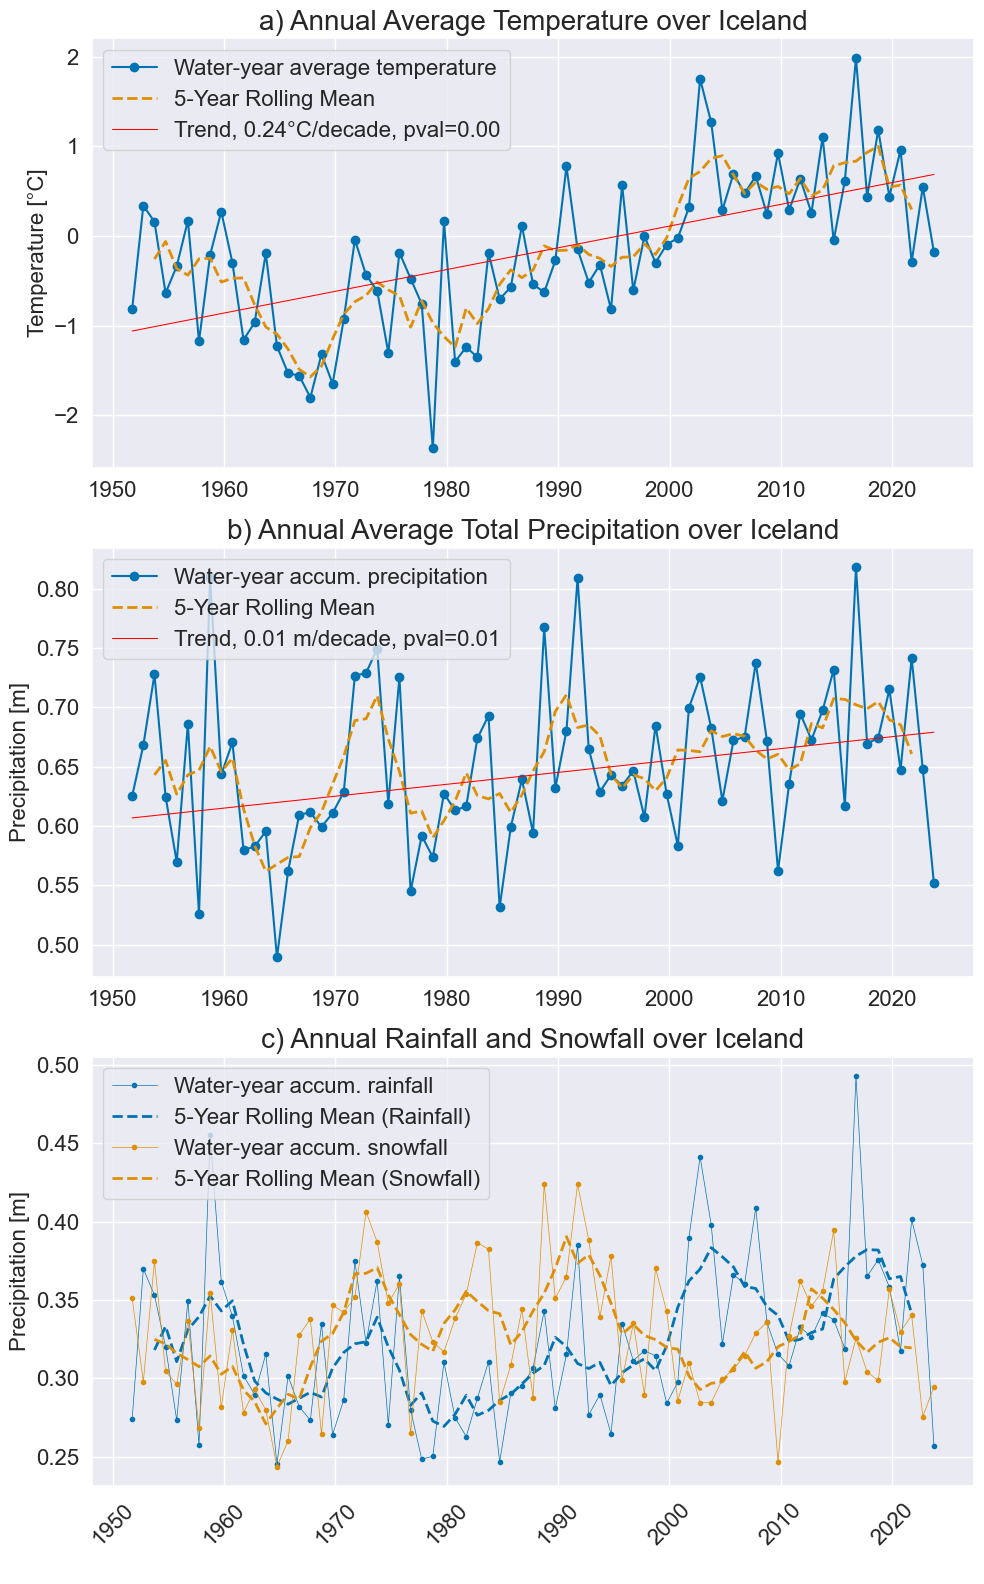

In [4]:


# Set colorblind-friendly palette
# sns.set_palette("colorblind")

# Calculate the 5-year rolling mean for the temperature, precipitation, rainfall, and snowfall
water_year_avg_temp_df['5-Year Rolling Mean'] = water_year_avg_temp_df['Temperature (°C)'].rolling(window=5, center=True).mean()
water_year_accum_precip_df['5-Year Rolling Mean'] = water_year_accum_precip_df['Precipitation (m)'].rolling(window=5, center=True).mean()
water_year_accum_rainfall_df['5-Year Rolling Mean'] = water_year_accum_rainfall_df['Rainfall (m)'].rolling(window=5, center=True).mean()
water_year_accum_snowfall_df['5-Year Rolling Mean'] = water_year_accum_snowfall_df['Snowfall (m)'].rolling(window=5, center=True).mean()

# Prepare x-axis values (convert the dates to integers for trend calculation)
years_temp = np.arange(len(water_year_avg_temp_df))
years_precip = np.arange(len(water_year_accum_precip_df))

# Calculate Theil-Sen slopes
slope_temp, intercept_temp, _, _ = theilslopes(water_year_avg_temp_df['Temperature (°C)'].values, years_temp)
slope_precip, intercept_precip, _, _ = theilslopes(water_year_accum_precip_df['Precipitation (m)'].values, years_precip)

mk_result_temp = mk.original_test(water_year_avg_temp_df['Temperature (°C)'].values, alpha=0.05)
mk_result_precip = mk.original_test(water_year_accum_precip_df['Precipitation (m)'].values, alpha=0.05)

# Create the figure and three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 16))

# --- Plotting for Temperature (Top Subplot) ---
ax1.plot(water_year_avg_temp_df.index, water_year_avg_temp_df['Temperature (°C)'], label='Water-year average temperature', marker='o')
ax1.plot(water_year_avg_temp_df.index, water_year_avg_temp_df['5-Year Rolling Mean'], label='5-Year Rolling Mean', ls='--', lw=2)

# Add Theil-Sen trendline for temperature
trendline_temp = intercept_temp + slope_temp * years_temp
ax1.plot(water_year_avg_temp_df.index, trendline_temp, color='red', lw=0.75, label='Trend, %.2f°C/decade, pval=%.2f' % (slope_temp*10,mk_result_temp.p))

ax1.set_title('a) Annual Average Temperature over Iceland', fontsize=20)
ax1.set_ylabel('Temperature [°C]', fontsize=16)
ax1.legend(fontsize=16)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=16)

# --- Plotting for Precipitation (Middle Subplot) ---
ax2.plot(water_year_accum_precip_df.index, water_year_accum_precip_df['Precipitation (m)'], label='Water-year accum. precipitation', marker='o')
ax2.plot(water_year_accum_precip_df.index, water_year_accum_precip_df['5-Year Rolling Mean'], label='5-Year Rolling Mean', ls='--', lw=2)

# Add Theil-Sen trendline for precipitation
trendline_precip = intercept_precip + slope_precip * years_precip
ax2.plot(water_year_accum_precip_df.index, trendline_precip, color='red', lw=0.75, label='Trend, %.2f m/decade, pval=%.2f' % (slope_precip*10,mk_result_precip.p,))

ax2.set_title('b) Annual Average Total Precipitation over Iceland', fontsize=20)
ax2.set_ylabel('Precipitation [m]', fontsize=16)
ax2.legend(fontsize=16)
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=16)

# --- Plotting for Rainfall and Snowfall (Bottom Subplot) ---
ax3.plot(water_year_accum_rainfall_df.index, water_year_accum_rainfall_df['Rainfall (m)'], label='Water-year accum. rainfall', marker='o', color='C0', lw=0.5, markersize=3)
ax3.plot(water_year_accum_rainfall_df.index, water_year_accum_rainfall_df['5-Year Rolling Mean'], label='5-Year Rolling Mean (Rainfall)', ls='--', lw=2, color='C0')
ax3.plot(water_year_accum_snowfall_df.index, water_year_accum_snowfall_df['Snowfall (m)'], label='Water-year accum. snowfall', marker='o', color='C1', lw=0.5, markersize=3)
ax3.plot(water_year_accum_snowfall_df.index, water_year_accum_snowfall_df['5-Year Rolling Mean'], label='5-Year Rolling Mean (Snowfall)', ls='--', lw=2, color='C1')

ax3.set_title('c) Annual Rainfall and Snowfall over Iceland', fontsize=20)
ax3.set_xlabel(' ', fontsize=16)
ax3.set_ylabel('Precipitation [m]', fontsize=16)
ax3.legend(fontsize=16)
ax3.grid(True)
ax3.tick_params(axis='both', which='major', labelsize=16)

plt.xticks(rotation=45)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Save the figure
# plt.savefig(Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\Changes in streamflow in Iceland\paper\Figures\Figures\temp_precip_rainfall_snowfall_1951_2024_with_trends.png"), dpi=300)

# Display the figure
plt.show()


# Now as anomalies from the long-term mean:

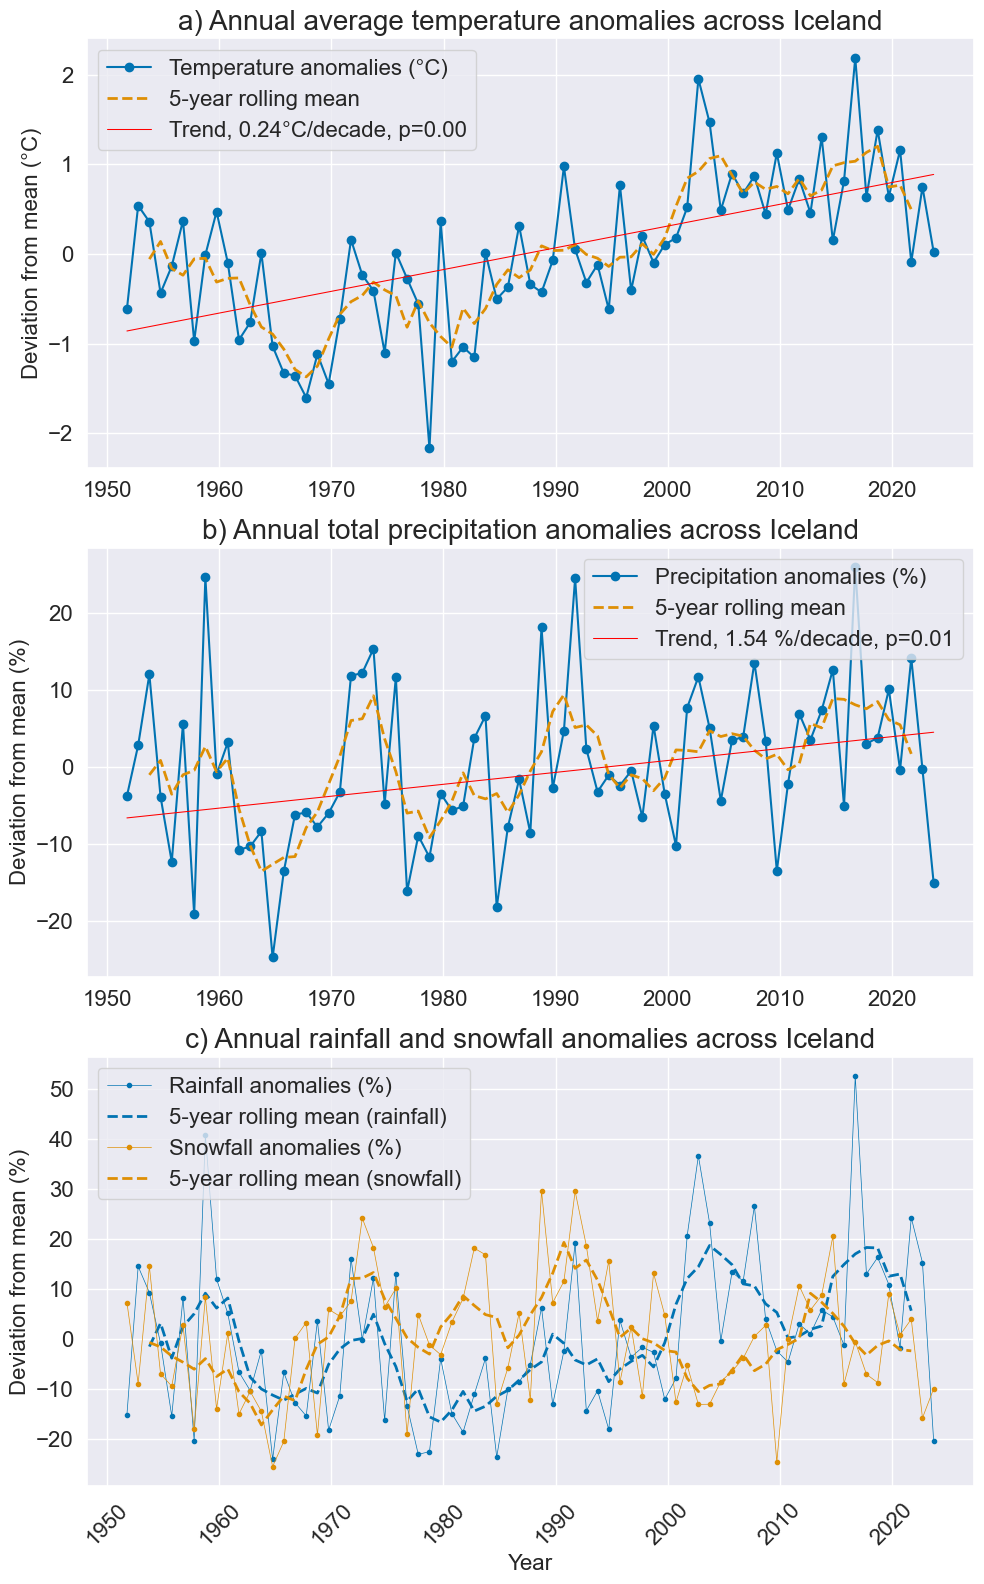

In [15]:
# --- Calculate deviations from the mean ---
# Temperature: deviation in °C
mean_temp = water_year_avg_temp_df['Temperature (°C)'].mean()
water_year_avg_temp_df['Temperature Deviation (°C)'] = water_year_avg_temp_df['Temperature (°C)'] - mean_temp

# Precipitation, Rainfall, and Snowfall: percent deviations
mean_precip = water_year_accum_precip_df['Precipitation (m)'].mean()
mean_rainfall = water_year_accum_rainfall_df['Rainfall (m)'].mean()
mean_snowfall = water_year_accum_snowfall_df['Snowfall (m)'].mean()

water_year_accum_precip_df['Precipitation Deviation (%)'] = (water_year_accum_precip_df['Precipitation (m)'] - mean_precip) / mean_precip * 100
water_year_accum_rainfall_df['Rainfall Deviation (%)'] = (water_year_accum_rainfall_df['Rainfall (m)'] - mean_rainfall) / mean_rainfall * 100
water_year_accum_snowfall_df['Snowfall Deviation (%)'] = (water_year_accum_snowfall_df['Snowfall (m)'] - mean_snowfall) / mean_snowfall * 100

# --- Calculate 5-year rolling means for deviations ---
water_year_avg_temp_df['5-Year Rolling Mean (Temp Deviation)'] = water_year_avg_temp_df['Temperature Deviation (°C)'].rolling(window=5, center=True).mean()
water_year_accum_precip_df['5-Year Rolling Mean (Precip Deviation)'] = water_year_accum_precip_df['Precipitation Deviation (%)'].rolling(window=5, center=True).mean()
water_year_accum_rainfall_df['5-Year Rolling Mean (Rainfall Deviation)'] = water_year_accum_rainfall_df['Rainfall Deviation (%)'].rolling(window=5, center=True).mean()
water_year_accum_snowfall_df['5-Year Rolling Mean (Snowfall Deviation)'] = water_year_accum_snowfall_df['Snowfall Deviation (%)'].rolling(window=5, center=True).mean()

# Prepare x-axis values for trend calculations
years_temp = np.arange(len(water_year_avg_temp_df))
years_precip = np.arange(len(water_year_accum_precip_df))

# Calculate Theil-Sen slopes
slope_temp, intercept_temp, _, _ = theilslopes(water_year_avg_temp_df['Temperature Deviation (°C)'].values, years_temp)
slope_precip, intercept_precip, _, _ = theilslopes(water_year_accum_precip_df['Precipitation Deviation (%)'].values, years_precip)

# Mann-Kendall trend test results for temperature and precipitation
mk_result_temp = mk.original_test(water_year_avg_temp_df['Temperature Deviation (°C)'].values, alpha=0.05)
mk_result_precip = mk.original_test(water_year_accum_precip_df['Precipitation Deviation (%)'].values, alpha=0.05)

# --- Create the figure and three subplots ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 16))

# --- Plotting for Temperature (Top Subplot) ---
ax1.plot(water_year_avg_temp_df.index, water_year_avg_temp_df['Temperature Deviation (°C)'], label='Temperature anomalies (°C)', marker='o')
ax1.plot(water_year_avg_temp_df.index, water_year_avg_temp_df['5-Year Rolling Mean (Temp Deviation)'], label='5-year rolling mean', ls='--', lw=2)

# Add Theil-Sen trendline for temperature
trendline_temp = intercept_temp + slope_temp * years_temp
ax1.plot(water_year_avg_temp_df.index, trendline_temp, color='red', lw=0.75, label='Trend, %.2f°C/decade, p=%.2f' % (slope_temp*10, mk_result_temp.p))

ax1.set_title('a) Annual average temperature anomalies across Iceland', fontsize=20)
ax1.set_ylabel('Deviation from mean (°C)', fontsize=16)
ax1.legend(fontsize=16)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=16)

# --- Plotting for Precipitation (Middle Subplot) ---
ax2.plot(water_year_accum_precip_df.index, water_year_accum_precip_df['Precipitation Deviation (%)'], label='Precipitation anomalies (%)', marker='o')
ax2.plot(water_year_accum_precip_df.index, water_year_accum_precip_df['5-Year Rolling Mean (Precip Deviation)'], label='5-year rolling mean', ls='--', lw=2)

# Add Theil-Sen trendline for precipitation
trendline_precip = intercept_precip + slope_precip * years_precip
ax2.plot(water_year_accum_precip_df.index, trendline_precip, color='red', lw=0.75, label='Trend, %.2f %%/decade, p=%.2f' % (slope_precip*10, mk_result_precip.p))

ax2.set_title('b) Annual total precipitation anomalies across Iceland', fontsize=20)
ax2.set_ylabel('Deviation from mean (%)', fontsize=16)
ax2.legend(fontsize=16)
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=16)

# --- Plotting for Rainfall and Snowfall (Bottom Subplot) ---
ax3.plot(water_year_accum_rainfall_df.index, water_year_accum_rainfall_df['Rainfall Deviation (%)'], label='Rainfall anomalies (%)', marker='o', color='C0', lw=0.5, markersize=3)
ax3.plot(water_year_accum_rainfall_df.index, water_year_accum_rainfall_df['5-Year Rolling Mean (Rainfall Deviation)'], label='5-year rolling mean (rainfall)', ls='--', lw=2, color='C0')
ax3.plot(water_year_accum_snowfall_df.index, water_year_accum_snowfall_df['Snowfall Deviation (%)'], label='Snowfall anomalies (%)', marker='o', color='C1', lw=0.5, markersize=3)
ax3.plot(water_year_accum_snowfall_df.index, water_year_accum_snowfall_df['5-Year Rolling Mean (Snowfall Deviation)'], label='5-year rolling mean (snowfall)', ls='--', lw=2, color='C1')

ax3.set_title('c) Annual rainfall and snowfall anomalies across Iceland', fontsize=20)
ax3.set_xlabel('Year', fontsize=16)
ax3.set_ylabel('Deviation from mean (%)', fontsize=16)
ax3.legend(fontsize=16)
ax3.grid(True)
ax3.tick_params(axis='both', which='major', labelsize=16)

plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\Changes in streamflow in Iceland\paper\Figures_Final\Figure1_era5l_anomalies.png"), dpi=300)
plt.savefig(Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\Changes in streamflow in Iceland\paper\Figures_Final\Figure1_era5l_anomalies.pdf"), dpi=300)

# Display the figure
plt.show()